## Load reference datasets

In [ ]:
#!pip install xlrd
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris
from scipy import signal


def smooth_line(src: list) -> list:
    return signal.savgol_filter(src, 3, 1)


X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame=True, return_X_y=True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "bc": X_raw_breast_cancer,
    "california": X_raw_california,
    "climate": climate_model_df,
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "slump": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
    ),
    "sonar": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
        header=None,
    ),
    "diabetes": X_raw_diab,
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "yeast": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data",
        sep="\s+",
        header=None,
    ),
    "iris": X_raw_iris,
    "libras": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",
        sep=",",
        header=None,
    ),
    "parkinsons": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",
        sep=",",
    ),
    "yacht": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
        sep="\s+",
        header=None,
    ),
    "ionosphere": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
        sep=",",
        header=None,
    ),
    "letter": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
        header=None,
    ),
    "spam": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    ),
    "credit": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data",
        header=None,
    ),
}

In [ ]:
from pathlib import Path

from hyperimpute.plugins.imputers import Imputers
from hyperimpute.utils.distributions import enable_reproducible_results
import hyperimpute.logger as log

from benchmark_imputation import evaluate_dataset_repeated_internal

enable_reproducible_results()

imputers = Imputers()


def get_imputer():
    return imputers.get(
        "hyperimpute",
        optimizer="simple",
        classifier_seed=["random_forest", "logistic_regression", "xgboost", "catboost"],
        regression_seed=[
            "random_forest_regressor",
            "linear_regression",
            "xgboost_regressor",
            "catboost_regressor",
        ],
    )


def evaluate_dataset_repeated(
    name,
    X_raw,
    y,
    ref_methods=["sklearn_ice", "sklearn_missforest", "sinkhorn", "miwae", "gain"],
    scenarios=["MAR", "MCAR", "MNAR"],
    miss_pct=[0.3],
    n_iter=3,
    debug=False,
):
    return evaluate_dataset_repeated_internal(
        name=name,
        evaluated_model=get_imputer(),
        X_raw=X_raw,
        y=y,
        ref_methods=ref_methods,
        scenarios=scenarios,
        miss_pct=miss_pct,
        n_iter=n_iter,
        debug=debug,
    )

## By dataset size

In [3]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
    header=None,
)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col])

last_col = df.columns[-1]
y = df[last_col]
X_raw = df.drop(columns=[last_col])

X_raw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,19,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0
1,8,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4
2,3,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3
3,13,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2
4,6,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3
19996,2,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3
19997,19,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2
19998,18,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5


In [ ]:
import json

results_by_df_size = {}
for subsample in [1000, 4000, 7000, 10000, 13000, 17000, 20000]:
    try:
        with open("general_results/error_by_df_size.json") as f:
            results_by_df_size = json.load(f)
    except BaseException:
        pass

    if str(subsample) in results_by_df_size:
        print("subsample already cached", subsample)
        continue

    print("subsample eval", subsample)
    X_local = X_raw.sample(subsample)
    y_local = y[X_local.index]

    results_by_df_size[subsample] = evaluate_dataset_repeated(
        f"subsample_{subsample}", X_local, y_local
    )

    with open("general_results/error_by_df_size.json", "w") as f:
        json.dump(results_by_df_size, f)

## By feature count

In [ ]:
import json

results_by_feat_count = {}

for feat_count in [2, 4, 6, 8, 10, 12, 14]:
    try:
        with open("general_results/error_by_df_feat_count.json") as f:
            results_by_feat_count = json.load(f)
    except BaseException:
        pass

    if str(feat_count) in results_by_feat_count:
        print("feat count cached", feat_count)
        continue

    print("eval feat count", feat_count)

    X_local = X_raw.sample(2000)
    y_local = y[X_local.index]
    X_local = X_local.iloc[:, :feat_count]

    results_by_feat_count[feat_count] = evaluate_dataset_repeated(
        f"feature_subsample_{feat_count}", X_local, y_local
    )

    with open("general_results/error_by_df_feat_count.json", "w") as f:
        json.dump(results_by_feat_count, f)

# Plots

In [91]:
#!pip install xlrd
import numpy as np
import pandas as pd
from scipy import signal
import json
from pathlib import Path
import shutil


def smooth_line(src: list) -> list:
    return signal.savgol_filter(src, 3, 1)

In [92]:
remap_models = {
    "Evaluated: hyperimpute": "hyperimpute",
    "Our method": "hyperimpute",
    "sklearn_missforest": "missforest",
    "sklearn_ice": "ice",
}


def process_testcase_data(results):
    error_data = {}

    for size in results:
        for scenario_idx in range(len(results[size]["rmse"])):
            headers = results[size]["headers"][2:]

            for idx, h in enumerate(headers):
                if h in remap_models:
                    headers[idx] = remap_models[h]

            rmse = results[size]["rmse"][scenario_idx][2:]
            wasserstein = results[size]["wasserstein"][scenario_idx][2:]
            scenario = results[size]["rmse"][scenario_idx][0]

            if scenario not in error_data:
                error_data[scenario] = {"rmse": {}, "wasserstein": {}}

            for idx, header in enumerate(headers):
                if header not in error_data[scenario]["rmse"]:
                    error_data[scenario]["rmse"][header] = {"mean": [], "std": []}
                    error_data[scenario]["wasserstein"][header] = {
                        "mean": [],
                        "std": [],
                    }

                error_data[scenario]["rmse"][header]["mean"].append(rmse[idx][0])
                error_data[scenario]["rmse"][header]["std"].append(rmse[idx][1])
                error_data[scenario]["wasserstein"][header]["mean"].append(
                    wasserstein[idx][0]
                )
                error_data[scenario]["wasserstein"][header]["std"].append(
                    wasserstein[idx][1]
                )
    return error_data


# by feature count
with open("general_results/error_by_df_feat_count.json") as f:
    results_by_feat_count = json.load(f)
# by df size
with open("general_results/error_by_df_size.json") as f:
    results_by_df_size = json.load(f)

# by miss ratio


def generate_mean_std(data, headers):
    _mean = []
    _std = []

    for scenario in data:
        local_mean = []
        local_std = []
        for vals in scenario:
            if isinstance(vals, list):
                local_mean.append(vals[0])
                local_std.append(vals[1])
            else:
                local_mean.append(vals)
                local_std.append(vals)
        _mean.append(local_mean)
        _std.append(local_std)
    _mean_df = pd.DataFrame(_mean, columns=headers)
    _std_df = pd.DataFrame(_std, columns=headers)

    return _mean_df, _std_df


f_miss_ratio = Path("general_results/error_by_miss_ratio.json")

if not f_miss_ratio.exists():
    for src in [
        "experiments_01_hyperimpute_with_hyperband",
        "experiments_01_hyperimpute_with_naive_search",
    ]:
        try:
            shutil.copy(Path(src) / "letter", f_miss_ratio)
        except BaseException as e:
            print(e)

with open("general_results/error_by_miss_ratio.json") as f:
    raw_results_by_miss_ratio = json.load(f)

    headers = raw_results_by_miss_ratio["headers"]

    rmse_mean, rmse_std = generate_mean_std(raw_results_by_miss_ratio["rmse"], headers)
    distr_mean, distr_std = generate_mean_std(
        raw_results_by_miss_ratio["wasserstein"], headers
    )

    raw_data = {
        "rmse": (rmse_mean, rmse_std),
        "wasserstein": (distr_mean, distr_std),
    }

    results_by_miss_ratio = {}

    for metric in raw_data:
        df, df_std = raw_data[metric]

        # Prediction norm
        num_df = df._get_numeric_data()
        num_df[num_df <= 0] = 1e-6

        for scenario in ["MAR", "MCAR", "MNAR"]:
            if scenario not in results_by_miss_ratio:
                results_by_miss_ratio[scenario] = {}

            for miss in [0.1, 0.3, 0.5, 0.7]:
                if miss not in results_by_miss_ratio[scenario]:
                    results_by_miss_ratio[scenario][miss] = {}

                local_df = df[df["Scenario"] == scenario].drop(columns=["Scenario"])
                local_df = local_df[local_df["miss_pct [0, 1]"] == miss].drop(
                    columns=["miss_pct [0, 1]"]
                )

                local_df = local_df.rename(columns=remap_models)

                if len(local_df) == 0:
                    continue

                local_df_std = df_std[df_std["Scenario"] == scenario].drop(
                    columns=["Scenario"]
                )
                local_df_std = local_df_std[
                    local_df_std["miss_pct [0, 1]"] == miss
                ].drop(columns=["miss_pct [0, 1]"])

                local_df_std = local_df_std.rename(columns=remap_models)

                if metric not in results_by_miss_ratio[scenario][miss]:
                    results_by_miss_ratio[scenario][miss][metric] = {}
                for col in local_df.columns:
                    if col not in results_by_miss_ratio[scenario][miss][metric]:
                        results_by_miss_ratio[scenario][miss][metric][col] = {
                            "mean": [],
                            "std": [],
                        }
                    results_by_miss_ratio[scenario][miss][metric][col]["mean"].append(
                        min(local_df[col].values[0], 0.5)
                    )
                    results_by_miss_ratio[scenario][miss][metric][col]["std"].append(
                        min(local_df_std[col].values[0], 0.01)
                    )

## Plot error by df size

scenario MAR


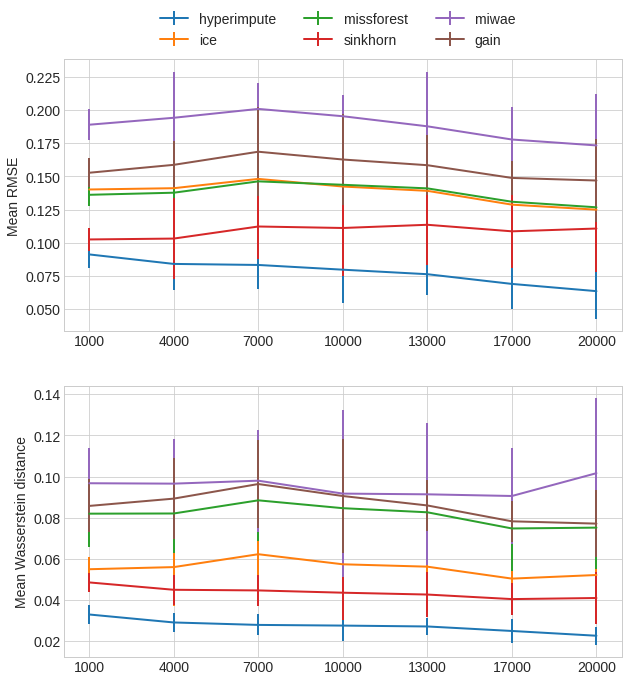

scenario MCAR


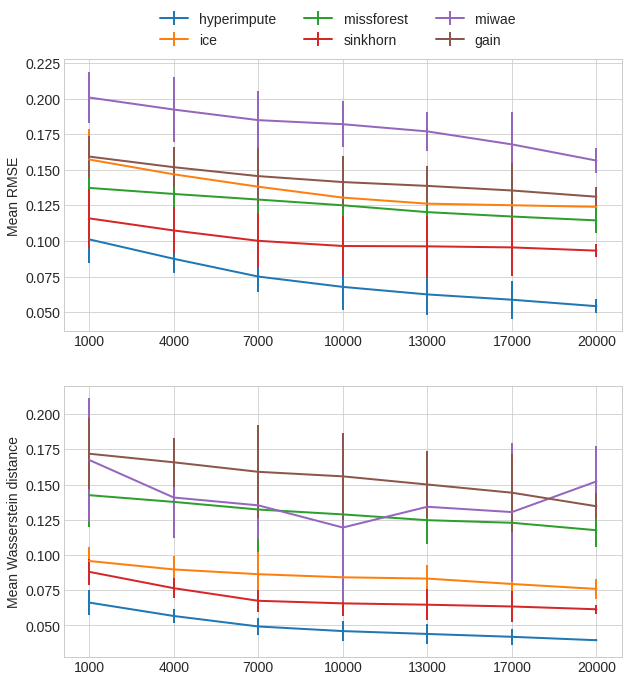

scenario MNAR


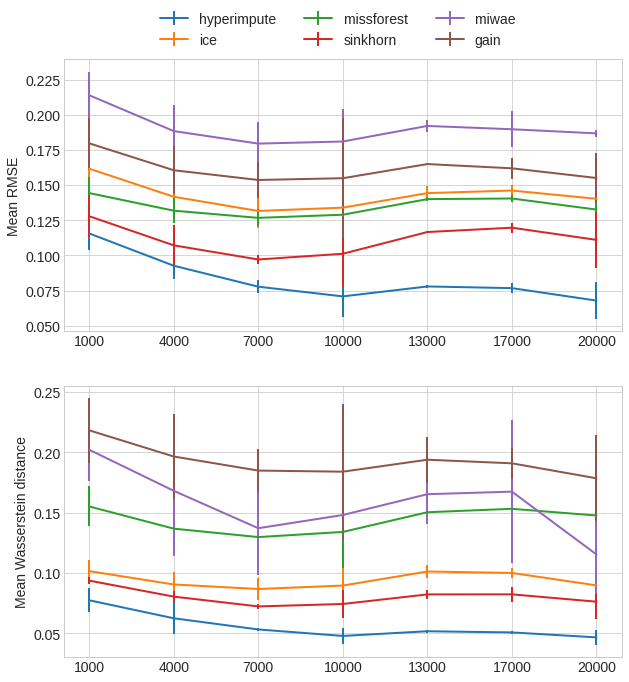

In [93]:
import numpy as np
import matplotlib.pyplot as plt

x_axis_df_size = list(results_by_df_size.keys())

fontsize = 14

output_dir = Path("diagrams")
output_dir.mkdir(parents=True, exist_ok=True)


map_keys = {"rmse": "Mean RMSE", "wasserstein": "Mean Wasserstein distance"}

error_by_df_size = process_testcase_data(results_by_df_size)


def generate_plot_for_ax_df_size(ax, scenario, metric):
    for model in error_by_df_size[scenario][metric]:
        datapoints = error_by_df_size[scenario][metric][model]["mean"]
        datapoints_std = error_by_df_size[scenario][metric][model]["std"]

        ax.errorbar(
            x_axis_df_size,
            smooth_line(np.asarray(datapoints)),
            yerr=np.asarray(datapoints_std),
            label=str(model),
            linewidth=2,
        )

    ax.set_xticks(x_axis_df_size, fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot_df_size(scenario):
    plt.style.use("seaborn-whitegrid")

    metrics = list(["rmse", "wasserstein"])
    fig, axs = plt.subplots(len(metrics), figsize=(10, 11))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax_df_size(axs[idx], scenario, metric)

        axs[idx].set_ylabel(map_keys[metric], fontsize=fontsize)

    # plt.title(f"{scenario} simulation with {miss} missingness", fontdict = {"fontsize": 150}, loc = "top")

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.15, 1.22),
        ncol=int(len(error_by_df_size[scenario]["rmse"]) / 2),
        prop={"size": fontsize},
    )
    # fig.suptitle(f"{scenario} simulation: error by dataset size", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_df_size_{scenario}.png")

    plt.show()


for scenario in ["MAR", "MCAR", "MNAR"]:
    print("scenario", scenario)
    generate_plot_df_size(scenario=scenario)

## By feature count


scenario  MAR


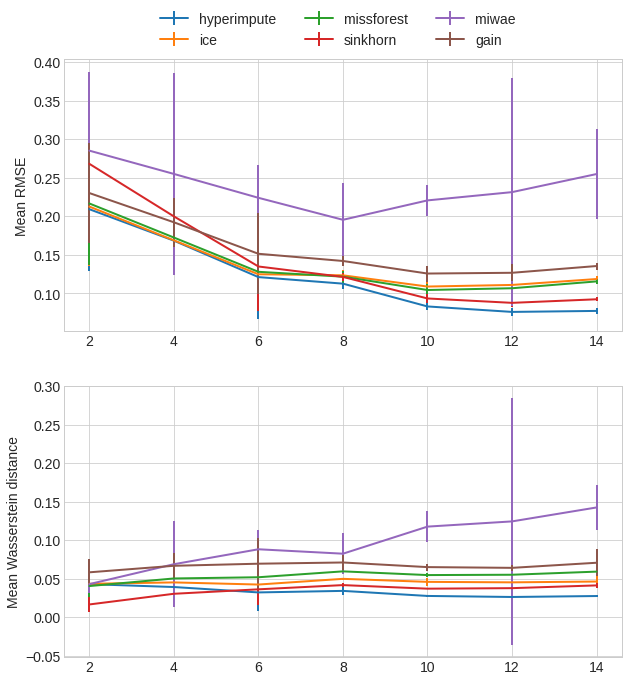

scenario  MCAR


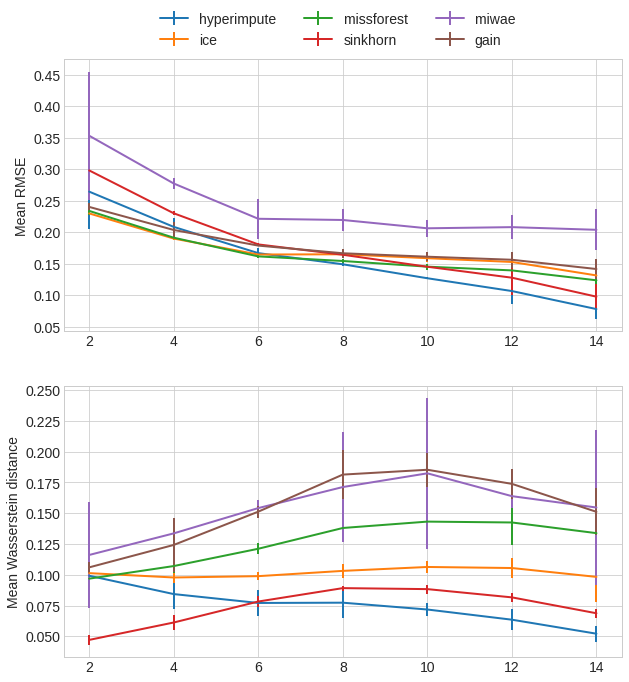

scenario  MNAR


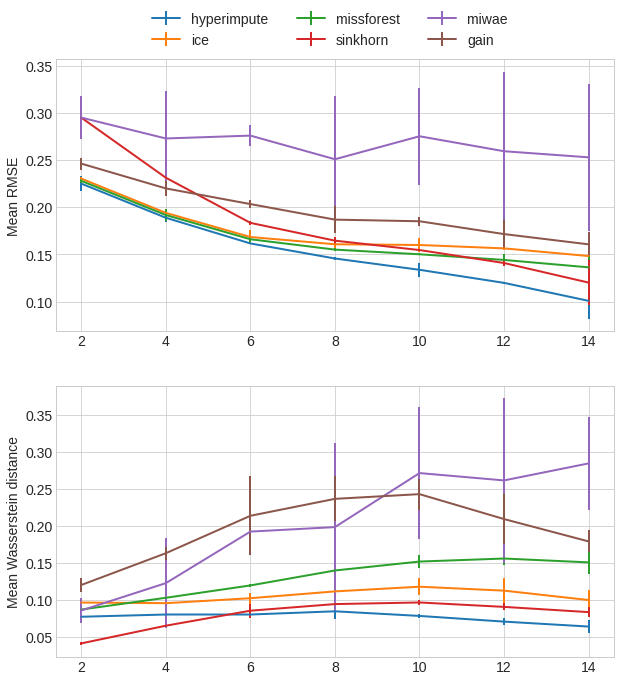

In [94]:
import numpy as np

x_axis_feat_count = list(results_by_feat_count.keys())

fontsize = 14

error_by_feat_count = process_testcase_data(results_by_feat_count)


def generate_plot_for_ax_feat_count(ax, scenario, metric):
    ## We selected the same dataset from every model, and average across missingness pct
    for model in error_by_feat_count[scenario][metric]:
        datapoints = error_by_feat_count[scenario][metric][model]["mean"]
        datapoints_std = error_by_feat_count[scenario][metric][model]["std"]

        ax.errorbar(
            x_axis_feat_count,
            smooth_line(np.asarray(datapoints)),
            yerr=np.asarray(datapoints_std),
            label=str(model),
            linewidth=2,
        )

    ax.set_xticks(x_axis_feat_count, fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot_feat_count(scenario):
    plt.style.use("seaborn-whitegrid")

    metrics = ["rmse", "wasserstein"]
    fig, axs = plt.subplots(len(metrics), figsize=(10, 11))

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax_feat_count(axs[idx], scenario, metric)
        axs[idx].set_ylabel(map_keys[metric], fontsize=fontsize)

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.15, 1.22),
        ncol=int(len(error_by_feat_count[scenario]["rmse"]) / 2),
        prop={"size": fontsize},
    )
    plt.savefig(output_dir / f"error_by_feature_cnt_{scenario}.png")

    plt.show()


for scenario in ["MAR", "MCAR", "MNAR"]:
    print("scenario ", scenario)
    generate_plot_feat_count(scenario)

## Plot by miss ratio

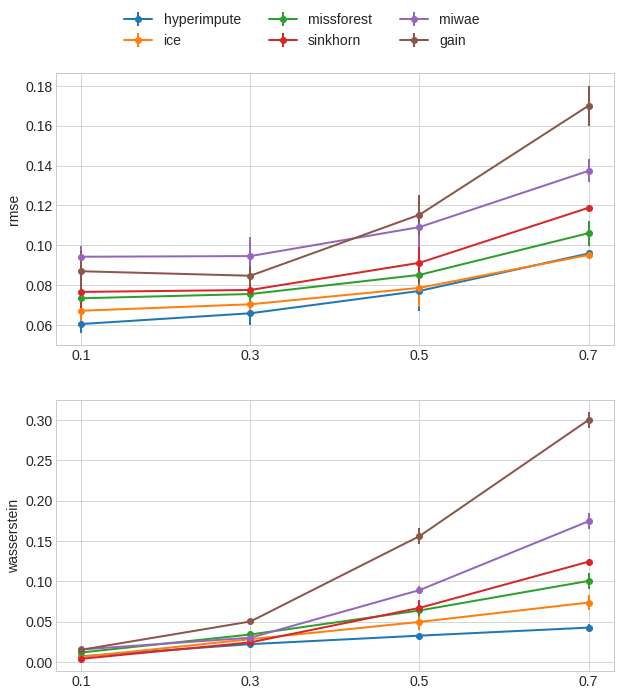

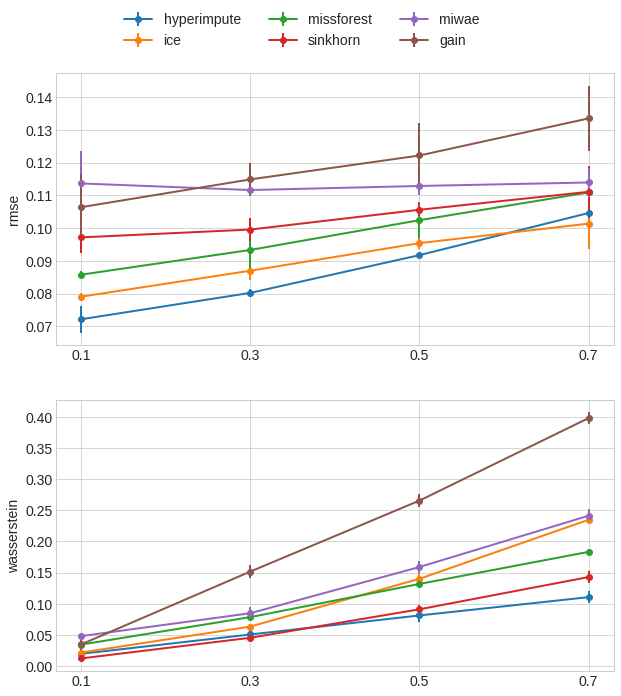

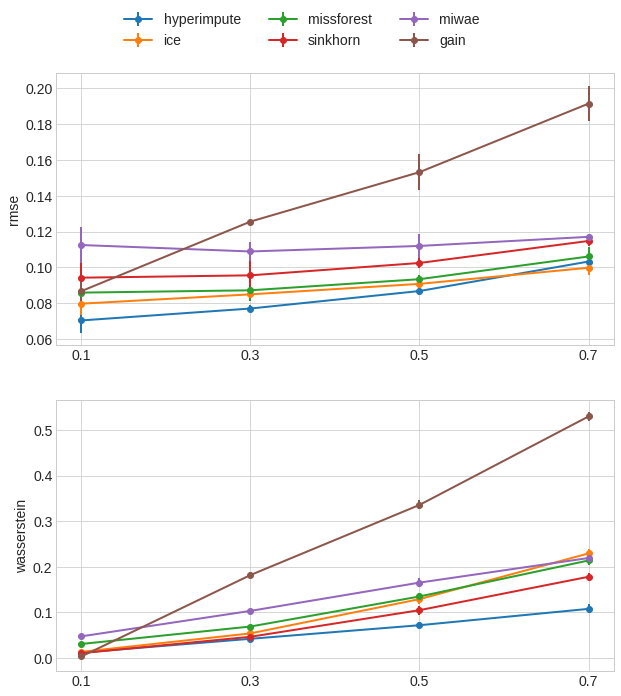

In [95]:
import numpy as np

x_axis_miss_ratio = [0.1, 0.3, 0.5, 0.7]

fontsize = 14

error_by_miss_ratio = results_by_miss_ratio


def generate_plot_for_ax_miss_ratio(ax, scenario, metric):
    barWidth = 1

    max_val = 0
    idx = 0

    for model in error_by_miss_ratio[scenario][0.1][metric]:

        datapoints = []
        datapoints_std = []

        for miss in error_by_miss_ratio[scenario]:
            if metric not in error_by_miss_ratio[scenario][miss]:
                continue

            local_res = error_by_miss_ratio[scenario][miss][metric][model]["mean"][0]
            local_res_std = error_by_miss_ratio[scenario][miss][metric][model]["std"][0]
            datapoints.append(local_res)
            datapoints_std.append(local_res_std)

        ax.errorbar(
            x_axis_miss_ratio,
            smooth_line(datapoints),
            yerr=datapoints_std,
            label=str(model),
            linewidth=2,
            marker="o",
        )

    ax.set_xticks(x_axis_miss_ratio, fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)

    return ax


def generate_plot_miss_ratio(scenario):
    plt.style.use("seaborn-whitegrid")

    metrics = list(error_by_miss_ratio[scenario][0.1].keys())
    if len(metrics) == 0:
        return

    fig, axs = plt.subplots(len(metrics), figsize=(10, 11))

    models_cnt = len(error_by_miss_ratio[scenario][0.1]["rmse"].keys())

    for idx, metric in enumerate(metrics):
        generate_plot_for_ax_miss_ratio(axs[idx], scenario, metric)
        axs[idx].set_ylabel(metric, fontsize=fontsize)

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0.1, 1.27),
        ncol=int(models_cnt / 2),
        prop={"size": fontsize},
    )
    # fig.suptitle(f"{scenario} simulation", fontsize=fontsize)
    plt.savefig(output_dir / f"error_by_miss_ratio_{scenario}.png")

    plt.show()


for scenario in ["MAR", "MCAR", "MNAR"]:
    generate_plot_miss_ratio(scenario)

## Plot group metrics

scenario MAR


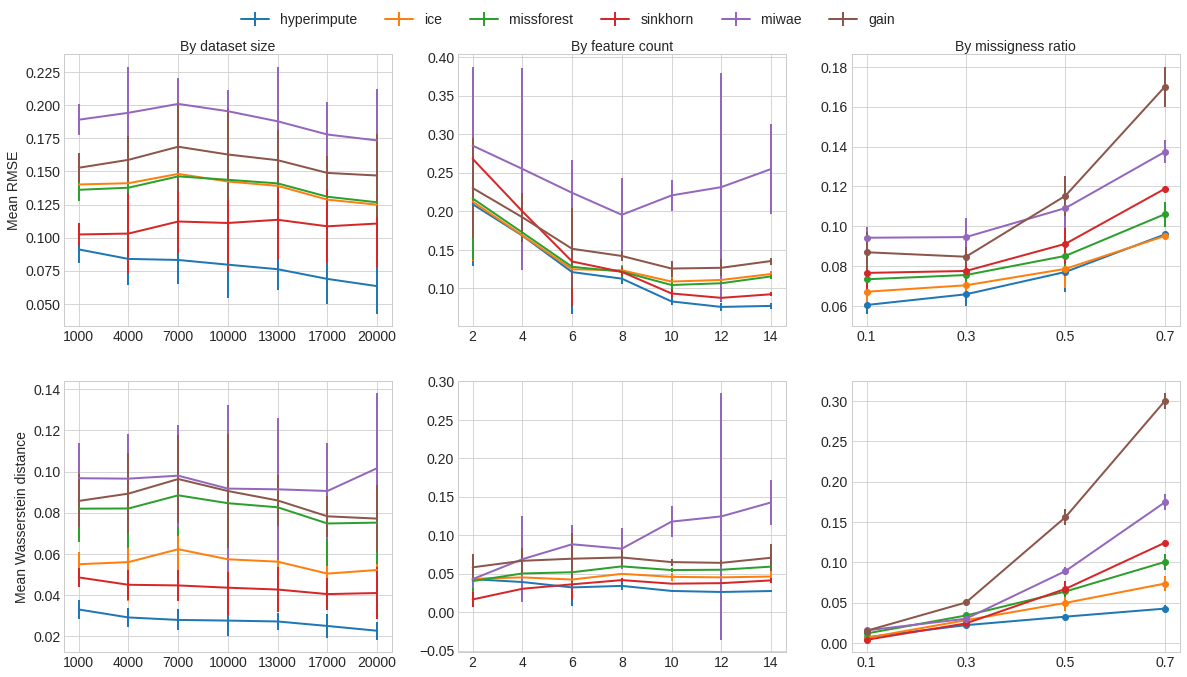

scenario MCAR


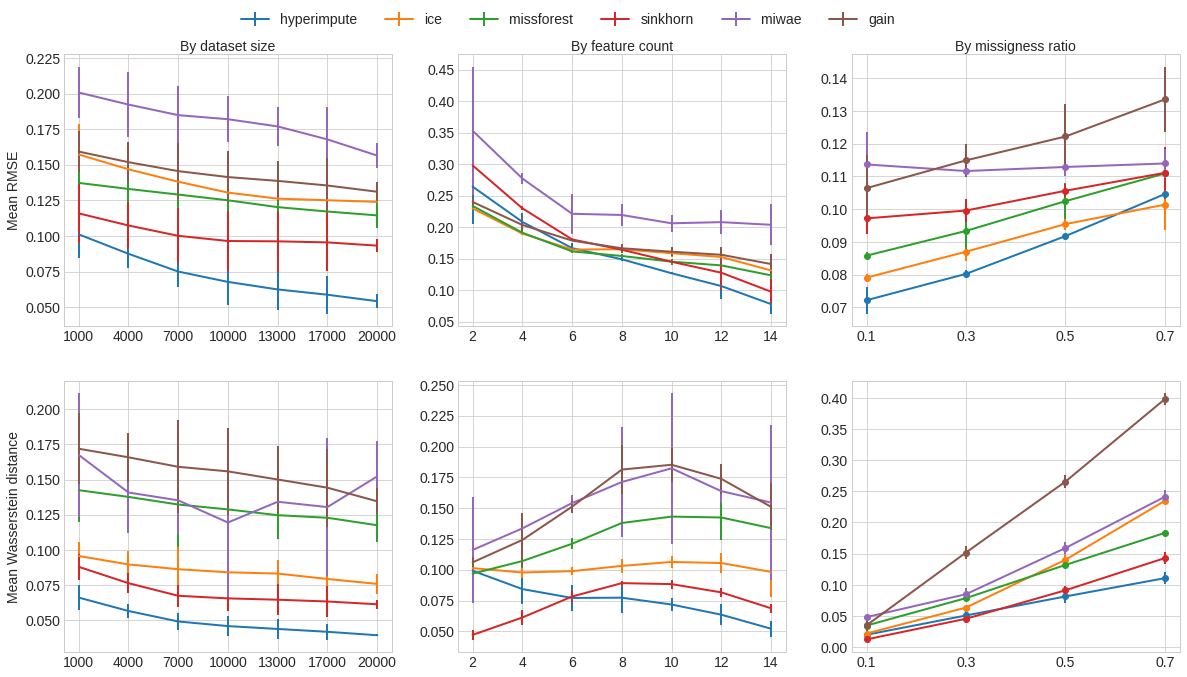

scenario MNAR


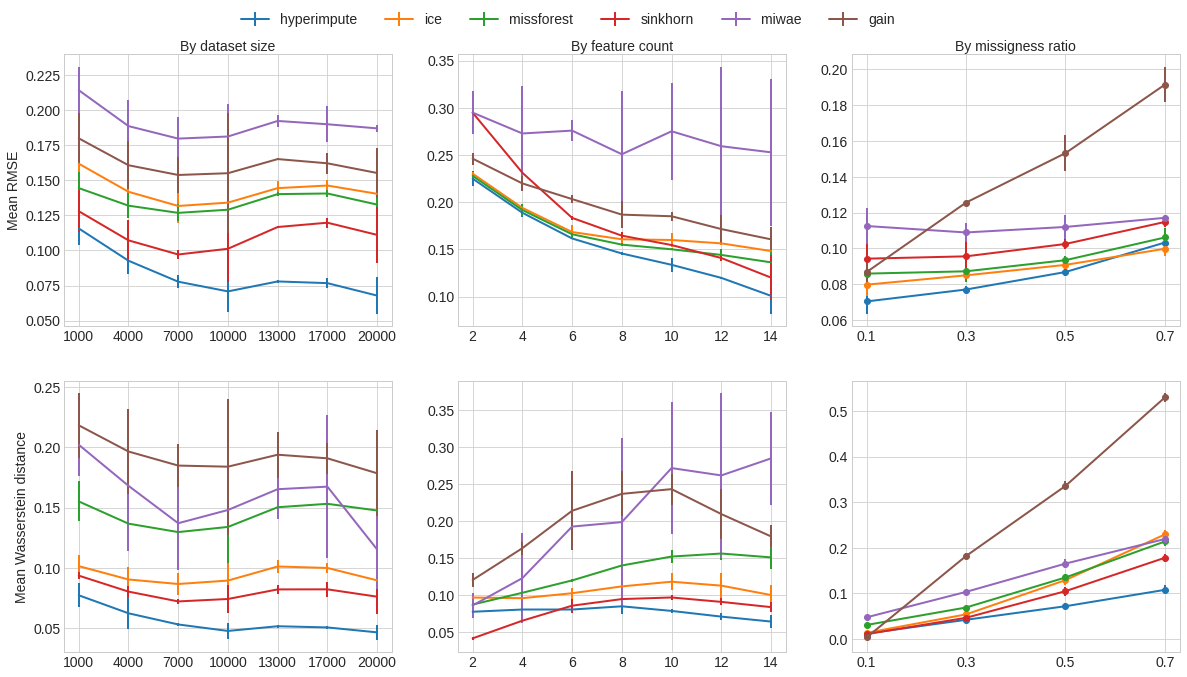

In [96]:
def generate_grouped_plot(scenario):
    global results_by_miss_ratio

    plt.style.use("seaborn-whitegrid")

    metrics = list(results_by_miss_ratio[scenario][0.1].keys())
    if len(metrics) == 0:
        return

    fig, axs = plt.subplots(len(metrics), 3, figsize=(20, 11))

    mods_miss_ratio = list(results_by_miss_ratio[scenario][0.1]["rmse"].keys())
    mods_feat_count = list(error_by_feat_count[scenario]["rmse"].keys())
    mods_df_size = list(error_by_df_size[scenario]["rmse"].keys())

    assert (
        mods_feat_count == mods_df_size
    ), f"Invalid models. {mods_feat_count} vs {mods_df_size}"
    assert (
        mods_feat_count == mods_miss_ratio
    ), f"Invalid models. {mods_feat_count} vs {mods_miss_ratio}"

    models_cnt = len(error_by_feat_count[scenario]["rmse"].keys())

    for row_idx, metric in enumerate(metrics):
        for col_idx, testcase_cbk in enumerate(
            [
                generate_plot_for_ax_df_size,
                generate_plot_for_ax_feat_count,
                generate_plot_for_ax_miss_ratio,
            ]
        ):
            testcase_cbk(axs[row_idx][col_idx], scenario, metric)

    axs[0][0].legend(
        loc="upper left",
        bbox_to_anchor=(0.5, 1.2),
        ncol=models_cnt,
        prop={"size": fontsize},
    )
    for idx, metric in enumerate(metrics):
        axs[idx][0].set_ylabel(map_keys[metric], fontsize=fontsize)

    for idx, testcase in enumerate(
        ["By dataset size", "By feature count", "By missigness ratio"]
    ):
        axs[0][idx].set_xlabel(testcase, fontsize=fontsize)
        axs[0][idx].xaxis.set_label_position("top")

    plt.savefig(output_dir / f"error_by_all_grouped_{scenario}.png")

    plt.show()


## normalize
new_results_by_miss_ratio = {}

for scenario in ["MAR", "MCAR", "MNAR"]:
    new_results_by_miss_ratio[scenario] = {}

    for miss in results_by_miss_ratio[scenario]:
        new_results_by_miss_ratio[scenario][miss] = {}
        for metric in results_by_miss_ratio[scenario][miss]:
            new_results_by_miss_ratio[scenario][miss][metric] = {}

            mods_feat_count = list(error_by_feat_count[scenario]["rmse"].keys())
            for mod in mods_feat_count:
                new_results_by_miss_ratio[scenario][miss][metric][
                    mod
                ] = results_by_miss_ratio[scenario][miss][metric][mod]
## normalize

error_by_miss_ratio = new_results_by_miss_ratio

for scenario in ["MAR", "MCAR", "MNAR"]:
    print("scenario", scenario)
    generate_grouped_plot(scenario)